# Steam Game Recommendation with Neural Collaborative Filtering (NCF)

In [ ]:
## Author: Shuwen
## Nov 20
## Python version: 3.7.12

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
# import libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.metrics import mean_absolute_error
#!pip install -q -U keras-tuner
#import keras_tuner as kt
from keras.layers import Dropout, Dense, Lambda, Activation, Embedding, Input, merge, Reshape, Flatten
import tensorflow.keras as ks
import os
import warnings
warnings.filterwarnings('ignore')
import keras
from keras import backend as K
from keras import initializers
from keras.models import Model

## Load and prepare the data

In [ ]:
# load dataset
ratings_df = pd.read_csv('/content/drive/My Drive/recsys/steam_reviews_rating.csv', sep = ',')
ratings_df

,author_steamid,app_name,ratings
0,76561198105266859,DRAGON BALL FighterZ,9
1,76561198121009893,DRAGON BALL FighterZ,5
2,76561198131795034,DRAGON BALL FighterZ,8
3,76561199005382787,DRAGON BALL FighterZ,7
4,76561198043105675,DRAGON BALL FighterZ,8
...,...,...,...
289146,76561198340055643,HITMAN™ 2,7
289147,76561197967769194,HITMAN™ 2,9
289148,76561197994883935,HITMAN™ 2,6
289149,76561198046164510,HITMAN™ 2,10


In [ ]:
# assign an item id to each item
item_ids = np.sort(ratings_df["app_name"].unique()).tolist()
imap = {x: i for i, x in enumerate(item_ids)}
ratings_df["item_id"] = ratings_df["app_name"].map(imap)
ratings_df.head(5)

,author_steamid,app_name,ratings,item_id
0,76561198105266859,DRAGON BALL FighterZ,9,58
1,76561198121009893,DRAGON BALL FighterZ,5,58
2,76561198131795034,DRAGON BALL FighterZ,8,58
3,76561199005382787,DRAGON BALL FighterZ,7,58
4,76561198043105675,DRAGON BALL FighterZ,8,58


In [ ]:
## active players = players who rated >= 15 games
group1 = ratings_df.groupby(['author_steamid'])['app_name'].count().reset_index()
group1
list1 = group1[group1['app_name']>=15]['author_steamid']
list1
## active games = games that have been played by >= 10 players
group2 = ratings_df['author_steamid'].groupby(ratings_df['app_name']).count().reset_index()
list2 = group2[(group2['author_steamid'] >=10)]['app_name']
list2

## combine above 2 conditions
ratings_df = ratings_df[(ratings_df['author_steamid'].isin(list1)) & (ratings_df['app_name'].isin(list2))]
ratings_df

,author_steamid,app_name,ratings,item_id
0,76561198105266859,DRAGON BALL FighterZ,9,58
1,76561198121009893,DRAGON BALL FighterZ,5,58
2,76561198131795034,DRAGON BALL FighterZ,8,58
3,76561199005382787,DRAGON BALL FighterZ,7,58
4,76561198043105675,DRAGON BALL FighterZ,8,58
...,...,...,...,...
289146,76561198340055643,HITMAN™ 2,7,122
289147,76561197967769194,HITMAN™ 2,9,122
289148,76561197994883935,HITMAN™ 2,6,122
289149,76561198046164510,HITMAN™ 2,10,122


In [ ]:
# rename column and change data type
ratings_df.columns = ['user_id','app_name','rating','item_id']
ratings_df['item_id'] = ratings_df['item_id'].astype(str)
ratings_df.head(5)

,user_id,app_name,rating,item_id
0,76561198105266859,DRAGON BALL FighterZ,9,58
1,76561198121009893,DRAGON BALL FighterZ,5,58
2,76561198131795034,DRAGON BALL FighterZ,8,58
3,76561199005382787,DRAGON BALL FighterZ,7,58
4,76561198043105675,DRAGON BALL FighterZ,8,58


In [ ]:
from sklearn.preprocessing import MinMaxScaler
import numpy as np

# apply min max normalization to rating
ratings_df['rating'] = MinMaxScaler().fit_transform(np.array(ratings_df['rating']).reshape(-1,1))
ratings_df

,user_id,app_name,rating,item_id
0,76561198105266859,DRAGON BALL FighterZ,0.888889,58
1,76561198121009893,DRAGON BALL FighterZ,0.444444,58
2,76561198131795034,DRAGON BALL FighterZ,0.777778,58
3,76561199005382787,DRAGON BALL FighterZ,0.666667,58
4,76561198043105675,DRAGON BALL FighterZ,0.777778,58
...,...,...,...,...
289146,76561198340055643,HITMAN™ 2,0.666667,122
289147,76561197967769194,HITMAN™ 2,0.888889,122
289148,76561197994883935,HITMAN™ 2,0.555556,122
289149,76561198046164510,HITMAN™ 2,1.000000,122


In [ ]:
# map the userids and itemids given in the rating events to contiguous integer indexes
def mapdata(ratings_df):
  ratings_df["item_id"] = ratings_df["item_id"].astype(str)
  ratings_df["user_id"] = ratings_df["user_id"].astype(str)
  ratings_df["rating"]  = ratings_df["rating"].values.astype(np.float32)
  user_ids = np.sort(ratings_df["user_id"].unique()).tolist()
  umap = {x: i for i, x in enumerate(user_ids)}
  item_ids = np.sort(ratings_df["item_id"].unique()).tolist()
  imap = {x: i for i, x in enumerate(item_ids)}
  ratings_df["user_id"] = ratings_df["user_id"].map(umap) # swap userid for user index
  ratings_df["item_id"] = ratings_df["item_id"].map(imap) # swap itemid for item index
  return ratings_df, umap, imap

In [ ]:
ratings_df, umap, imap = mapdata(ratings_df)

## Model Building and Evaluation

In [ ]:
# train/test split
from sklearn.model_selection import train_test_split
train, test = train_test_split(ratings_df, test_size=0.20, random_state=42)

In [ ]:
# define the model
def definemodel(nusers, nitems, embeddingsdim):
    
    #add 1 to the number of items & users because the embedding layers need an 
    #extra row for items & users that do not appear in the training dataset. 
    
    # create item embedding layers
    input_items = ks.layers.Input(shape=[1], name="item_input")
    embed_items = ks.layers.Embedding(nitems + 1, embeddingsdim, name="item_embedding")(input_items)
    items_flat  = ks.layers.Flatten()(embed_items)
    
    # create user embedding layers
    input_users = ks.layers.Input(shape=[1], name="user_input")
    embed_users = ks.layers.Embedding(nusers + 1, embeddingsdim, name="user_embedding")(input_users)
    users_flat  = ks.layers.Flatten()(embed_users)

    # predicted rating = dotproduct of user and item embeddings
    # concatenate the user and item embeddings and use this as input into a 2-layer classification network
    out  = ks.layers.Dot(name="dot-product", axes=1)([items_flat, users_flat])
    out = ks.layers.Concatenate()([items_flat, users_flat])
    out = ks.layers.Dense(2, input_dim = 3, activation='sigmoid')(out) # Dense tried 2 to 128, input_dim tried 2-10, activation function tried reLu and sigmoid
    out = ks.layers.Dropout(0.5)(out) # use Dropout to avoid overfitting, tried from 0.1 to 0.6
    #out = ks.layers.BatchNormalization()(out) # also tried batch normalization to avoid overfitting, perform worse than dropout
    out = ks.layers.Dense(1, activation='sigmoid')(out)

    model = ks.Model([input_items, input_users], out)   
    
    return model

In [ ]:
# compile the model  
embeddingsdim = 3 # tried 2 to 15
model = definemodel(len(umap), len(imap), embeddingsdim)
model.compile(optimizer='adam', loss= 'mean_squared_error', metrics=['RootMeanSquaredError']) #optimizer also tried sgd # ks.metrics.MeanAbsoluteError()
model.summary()

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 item_input (InputLayer)        [(None, 1)]          0           []                               
                                                                                                  
 user_input (InputLayer)        [(None, 1)]          0           []                               
                                                                                                  
 item_embedding (Embedding)     (None, 1, 3)         945         ['item_input[0][0]']             
                                                                                                  
 user_embedding (Embedding)     (None, 1, 3)         44118       ['user_input[0][0]']             
                                                                                            

In [ ]:
# train the model, batch size try 4 to 64 
hist = model.fit([train.item_id, train.user_id], train.rating, batch_size=6, epochs=5, verbose=1, 
                 validation_data=([test.item_id, test.user_id], test.rating))

Epoch 1/5
38553/38553 [==============================] - 81s 2ms/step - loss: 0.0472 - root_mean_squared_error: 0.2172 - val_loss: 0.0467 - val_root_mean_squared_error: 0.2162
Epoch 2/5
38553/38553 [==============================] - 81s 2ms/step - loss: 0.0471 - root_mean_squared_error: 0.2171 - val_loss: 0.0466 - val_root_mean_squared_error: 0.2160
Epoch 3/5
38553/38553 [==============================] - 80s 2ms/step - loss: 0.0471 - root_mean_squared_error: 0.2169 - val_loss: 0.0466 - val_root_mean_squared_error: 0.2158
Epoch 4/5
38553/38553 [==============================] - 79s 2ms/step - loss: 0.0470 - root_mean_squared_error: 0.2169 - val_loss: 0.0466 - val_root_mean_squared_error: 0.2159
Epoch 5/5
38553/38553 [==============================] - 79s 2ms/step - loss: 0.0470 - root_mean_squared_error: 0.2169 - val_loss: 0.0466 - val_root_mean_squared_error: 0.2160


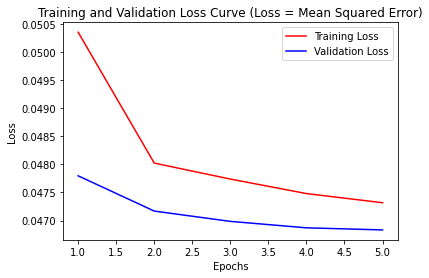

In [ ]:
# display the model training history
train_loss = hist.history['loss']
val_loss = hist.history['val_loss']
epochs = range(1, len(train_loss) + 1)
plt.plot(epochs, train_loss, color='r', label='Training Loss')
plt.plot(epochs, val_loss, color='b', label='Validation Loss')
plt.title("Training and Validation Loss Curve (Loss = Mean Squared Error)")
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

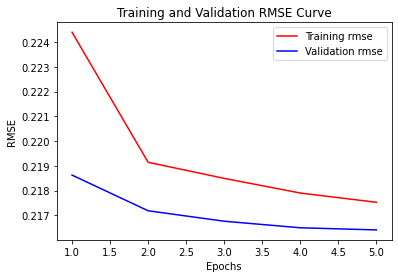

In [ ]:
# RMSE plot
train_rmse = hist.history['root_mean_squared_error']
val_rmse = hist.history['val_root_mean_squared_error']
epochs = range(1, len(train_rmse) + 1)
plt.plot(epochs, train_rmse, color='r', label='Training rmse')
plt.plot(epochs, val_rmse, color='b', label='Validation rmse')
plt.title("Training and Validation RMSE Curve")
plt.xlabel('Epochs')
plt.ylabel('RMSE')
plt.legend()

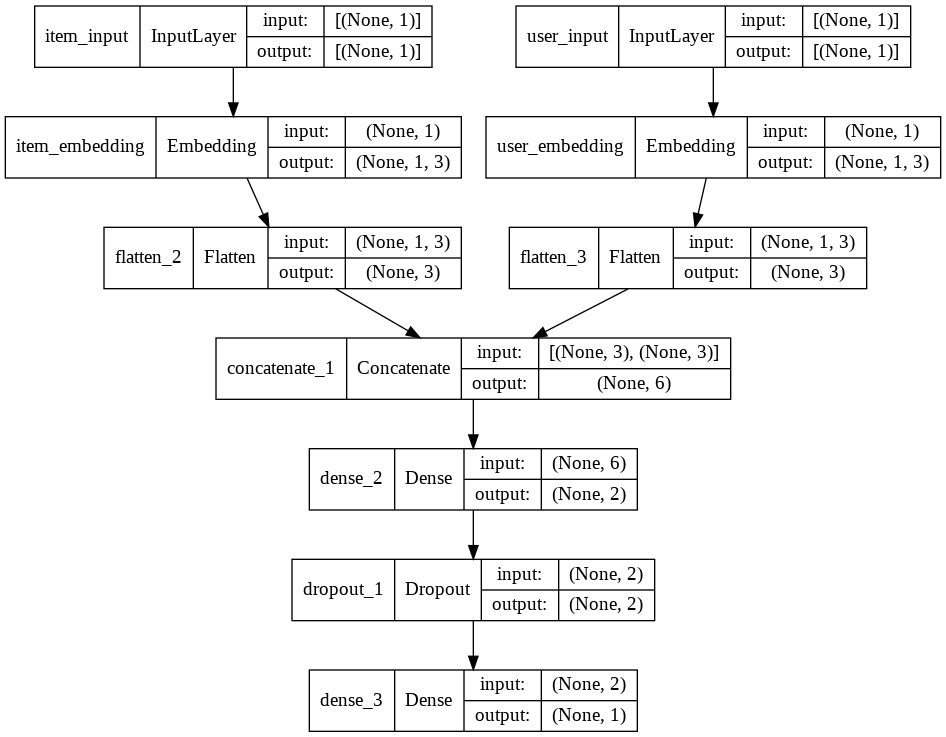

In [ ]:
ks.utils.plot_model(model, 
                    to_file="model.png", 
                    show_shapes=True,
                    show_layer_names=True,
                    expand_nested=True)

In [ ]:
# compute train MAE
predictions1 = model.predict([train.item_id, train.user_id])

# show a sample of the predictions
for i in range(0,5):
  print("actual=",train.rating.iloc[i],"pred=",predictions1[i][0], "abserr=",abs(train.rating.iloc[i]-predictions1[i][0])) 
  
# compute MAE - how accurate
print("MAE=",mean_absolute_error(train.rating, predictions1))

actual= 0.7777778 pred= 0.73021674 abserr= 0.04756105
actual= 0.44444445 pred= 0.6153358 abserr= 0.17089137
actual= 1.0 pred= 0.7138541 abserr= 0.28614593
actual= 0.11111111 pred= 0.5885036 abserr= 0.4773925
actual= 0.5555556 pred= 0.7696742 abserr= 0.2141186
MAE= 0.1640256


In [ ]:
# test the model
predictions = model.predict([test.item_id, test.user_id])

# show a sample of the predictions
for i in range(0,5):
  print("actual=",test.rating.iloc[i],"pred=",predictions[i][0], "abserr=",abs(test.rating.iloc[i]-predictions[i][0])) 
  
# compute MAE - how accurate
print("MAE=",mean_absolute_error(test.rating, predictions))

actual= 1.0 pred= 0.7298455 abserr= 0.27015448
actual= 0.7777778 pred= 0.7917532 abserr= 0.013975382
actual= 0.5555556 pred= 0.8030648 abserr= 0.24750924
actual= 0.7777778 pred= 0.7965945 abserr= 0.01881671
actual= 0.6666667 pred= 0.7317101 abserr= 0.06504339
MAE= 0.1693204


In [ ]:
# test the model (alternative method)
# compute the metrics defined when the model was compiled
model.evaluate([test['item_id'],test['user_id']],test['rating'])

1808/1808 [==============================] - 2s 1ms/step - loss: 0.0457 - root_mean_squared_error: 0.2138


[0.04572966322302818, 0.21384495496749878]

In [ ]:
# to show the metrics that are defined for the model
model.metrics_names

['loss', 'root_mean_squared_error']

In [ ]:
# precision in train set
m = ks.metrics.Precision()
m.update_state(train.rating, predictions1)
m.result().numpy()

0.9852453

In [ ]:
# precision in test set
m = ks.metrics.Precision()
m.update_state(test.rating, predictions)
m.result().numpy()

0.98537064

# Make recommendations for a given user

In [ ]:
ratings_df.head()

,user_id,app_name,rating,item_id
0,6658,DRAGON BALL FighterZ,0.888889,268
1,7404,DRAGON BALL FighterZ,0.444444,268
2,7881,DRAGON BALL FighterZ,0.777778,268
3,14663,DRAGON BALL FighterZ,0.666667,268
4,3055,DRAGON BALL FighterZ,0.777778,268


In [ ]:
# map item name and id together and store in the dictionary
ratingslookup = dict(zip(ratings_df["item_id"],ratings_df["app_name"]))
ratingslookup

{0: '20XX',
 1: 'A Hat in Time',
 2: 'Ancestors Legacy',
 3: 'Far Cry 5',
 4: 'Farm Manager 2018',
 5: 'Farm Together',
 6: 'Farming Simulator 19',
 7: 'Finding Paradise',
 8: 'Fishing: Barents Sea',
 9: 'Football Manager 2019',
 10: 'For Honor',
 11: 'For The King',
 12: 'Foundation',
 13: 'Arma 3',
 14: 'Freeman: Guerrilla Warfare',
 15: 'Frostpunk',
 16: 'GOD EATER 3',
 17: 'GRIS',
 18: "Garry's Mod",
 19: 'Getting Over It with Bennett Foddy',
 20: 'Ghost of a Tale',
 21: 'Golf It!',
 22: 'Grand Theft Auto V',
 23: "Grimm's Hollow",
 24: 'Artifact',
 25: 'Guacamelee! Super Turbo Championship Edition',
 26: 'Gunpoint',
 27: 'HITMAN™ 2',
 28: 'Hades',
 29: 'Half-Life',
 30: 'Half-Life 2: Episode Two',
 31: 'Half-Life: Alyx',
 32: 'Hearts of Iron IV',
 33: 'Helltaker',
 34: 'Heroes of Hammerwatch',
 35: "Assassin's Creed Odyssey",
 36: 'Hollow Knight',
 37: 'Hotline Miami',
 38: 'House Flipper',
 39: 'Human: Fall Flat',
 40: 'HuniePop',
 41: 'Hunt Down The Freeman',
 42: 'Hunt: Showdow

In [ ]:
# Extract the item embeddings from the trained model
item_em = model.get_layer('item_embedding')
item_em_weights = item_em.get_weights()[0]
item_em_weights.shape

(315, 3)

In [ ]:
#save two tsv files: one containing the embedding weights, and the other containing the corresponding item title.
out_v = open('vecs.tsv', 'w')
out_m = open('meta.tsv', 'w',encoding='utf-8')
iids =list(ratings_df.item_id.unique())
for i in iids:
    title = ratingslookup[i]
    embeddings = item_em_weights[i]
    out_m.write(title + "\n")
    out_v.write('\t'.join([str(x) for x in embeddings]) + "\n")
out_v.close()
out_m.close()

In [ ]:
# get unique user id
ratings_df['user_id'].unique()

array([ 6658,  7404,  7881, ...,  5389, 10348,  2047])

In [ ]:
#select a target user and make ratings predictions for all items
targetuser = 6658
user = np.array([targetuser for i in range(len(iids))]) # get a duplicate userid for every possible item
pred = model.predict([np.array(iids), user])
pred

array([[0.6999063 ],
       [0.7094031 ],
       [0.68235713],
       [0.708156  ],
       [0.7094471 ],
       [0.5870518 ],
       [0.7170944 ],
       [0.69974875],
       [0.7110105 ],
       [0.69949424],
       [0.672351  ],
       [0.6885595 ],
       [0.676407  ],
       [0.66843134],
       [0.7022263 ],
       [0.6755774 ],
       [0.66512996],
       [0.58685607],
       [0.70071155],
       [0.6601502 ],
       [0.6635344 ],
       [0.6937922 ],
       [0.6895443 ],
       [0.67869186],
       [0.6984974 ],
       [0.6721164 ],
       [0.6792469 ],
       [0.6880293 ],
       [0.6593358 ],
       [0.6949618 ],
       [0.66598034],
       [0.69310004],
       [0.66630894],
       [0.5868697 ],
       [0.5960936 ],
       [0.6345382 ],
       [0.70014286],
       [0.6378091 ],
       [0.71144474],
       [0.6008852 ],
       [0.70265955],
       [0.59370685],
       [0.70234287],
       [0.6985659 ],
       [0.67422295],
       [0.6529652 ],
       [0.69122374],
       [0.688

In [ ]:
#sort the rating predictions, and retrieve the index of the highest 5. 
pred = pred.reshape(-1) #reshape to single dimension
preditem_idxs = (-pred).argsort()[0:10]
print(preditem_idxs)

# # display the recommendations
# for idx in preditem_idxs:
#   print(ratings_df[ratings_df.item_id == idx][["item_id","app_name"]].drop_duplicates())

df_tmp = ratings_df[ratings_df['item_id'].isin(preditem_idxs)][["item_id","app_name"]].drop_duplicates()
df_tmp

[292  99   6 100 140 225  88 209  59 119]


,item_id,app_name
23191,6,Farming Simulator 19
60600,140,Sid Meier's Civilization V
66482,99,Pillars of Eternity II: Deadfire
80274,292,American Truck Simulator
111671,119,RollerCoaster Tycoon World
145378,100,BERSERK and the Band of the Hawk
214303,209,ULTRAKILL
220671,59,MORDHAU
233552,225,"Warhammer 40,000: Dawn of War III"
246904,88,Oxygen Not Included


In [ ]:
# for comparison, look at the items the target has rated most highly in the past
print("\nItems with high ratings from the target user\n","="*40)
toprated_itemids = ratings_df[ratings_df.user_id == targetuser].sort_values(by=['rating'], ascending=False).head(10).app_name
pd.DataFrame(toprated_itemids)


Items with high ratings from the target user


,app_name
287731,HITMAN™ 2
0,DRAGON BALL FighterZ
6597,Wallpaper Engine
34039,Middle-earth™: Shadow of War™
103097,Grand Theft Auto V
19597,NieR:Automata™
58238,Rise of the Tomb Raider
66770,Tom Clancy's Ghost Recon® Wildlands
119173,PLAYERUNKNOWN'S BATTLEGROUNDS
242622,Assassin's Creed Origins
